### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

Text(0.5, 1.0, 'tom area, m2')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


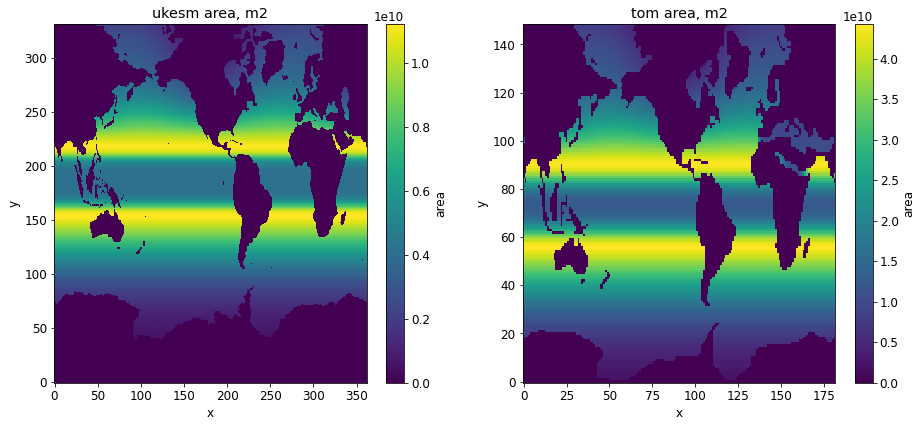

In [4]:
latmax_ukesm = 140
latmax_tom = 50

ukesm = xr.open_dataset('//gpfs/data/greenocean/software/resources/MEDUSA/PROC2/medusa_cj504_1y_2099_ptrc-T-CHLTADIC.nc')
tom = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_20200101_20201231_diad_T.nc')

tom.nav_lat[0,80].values

tomlat = np.arange(0,150,10)
tomlat_all = np.arange(0,149,1)
for i in range(0,150,10):
    tomlat[int(i/10)] = (tom.nav_lat[i,49].values)
    #print(np.nanmax(tom.nav_lat[i,:].values) - np.nanmin(tom.nav_lat[i,:].values))
ukesmlat = np.arange(0,330,20)
for i in range(0,330,20):
    ukesmlat[int(i/20)] = (ukesm.nav_lat[i,80].values)   
    #print(np.nanmax(ukesm.nav_lat[i,:].values) - np.nanmin(ukesm.nav_lat[i,:].values))

tommesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tommesh['area'] = tommesh.tmask[0,0,:,:] * tommesh.e1t[0,:,:] * tommesh.e2t[0,:,:]


ukmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
ukmesh['area'] = ukmesh.tmask[0,:,:] * ukmesh.e1t[:,:] * ukmesh.e2t[:,:]


ukesm_bylat = ukmesh['area'][0:latmax_ukesm,:].sum(dim = ['x'])
tom_bylat = tommesh['area'][0:latmax_tom,:].sum(dim = ['x'])

fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(14*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ukmesh['area'].plot(ax = axs[0])
tommesh['area'].plot(ax = axs[1])
axs[0].set_title('ukesm area, m2')
axs[1].set_title('tom area, m2')

In [5]:
w = glob.glob('./BSUB_extractions/EXTRACT/*1A*lathovmoller*nc')

print(w)

['./BSUB_extractions/EXTRACT/UKESM_1A_pco2_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_dpCO2_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/UKESM_1A_cflx_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_mldkz5_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/UKESM_1A_OCN_PCO2_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_Cflx_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_WIND_lathovmoller_1940_2100.nc', './BSUB_extractions/EXTRACT/TOM12_1A_cflx_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/UKESM_1A_OCN_DPCO2_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/UKESM_1A_somxl010_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/UKESM_1A_WIND_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/UKESM_1A_CO2FLUX_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_1A_pco2_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_pCO2_lat

In [6]:
def hovmol_ukesm(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_dff, stit, fnam):
    latmax_ukesm = 140
    
    #get what this variable looked like 1955-1959
    var_base = var.sel(time_counter=slice('1955-01', '1959-12')).groupby('time_counter.month').mean()

    fact = 1.1
    fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    tds = var 
    tds_tp = tds.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[0], vmin = tvmin, vmax = tvmax, cmap = tcmap)  
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[2], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[4], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[6], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[8], vmin = tvmin, vmax = tvmax, cmap = tcmap)

    tds = var.groupby('time_counter.month') - var_base
    tds_tp = tds.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[1], vmin = dmin, vmax = dmax, cmap = tcmap_diff)  
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[3], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[5], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[7], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T.plot(ax = axs[9], vmin = dmin, vmax = dmax, cmap = tcmap_diff)


    for i in range(0,10,1):
        axs[i].set_yticks(np.arange(0,330,20))
        axs[i].set_yticklabels(ukesmlat)
        axs[i].set_ylim([40,latmax_ukesm])
        axs[0].set_ylabel('approx. lat')

    ttit = ['full year', 'full year - (1955-1960)','DJF', 'DJF', 'MAM', 'MAM', 'JJA', 'JJA', 'SON', 'SON']
    for i in range(0,10):
        axs[i].set_title(ttit[i])

    fig.suptitle(stit)
    fig.savefig(fnam)
    plt.tight_layout()
    
    

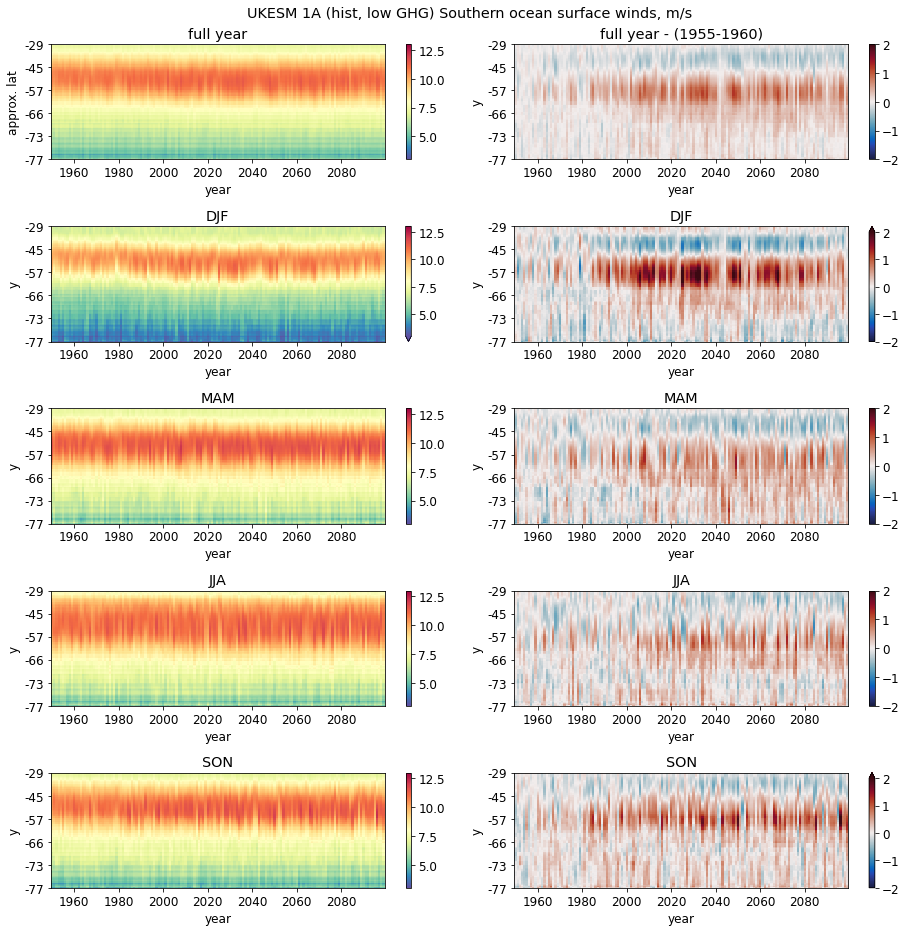

In [7]:
UKESM_1A_WIND = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_WIND_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_WIND_base_hovmoller.png'
stit = 'UKESM 1A (hist, low GHG) Southern ocean surface winds, m/s'
var = UKESM_1A_WIND

tvmin = 3
tvmax = 13
tcmap = 'Spectral_r'
tcmap_diff = cm.balance
dmin = -2
dmax = 2

hovmol_ukesm(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_diff, stit, fnam)





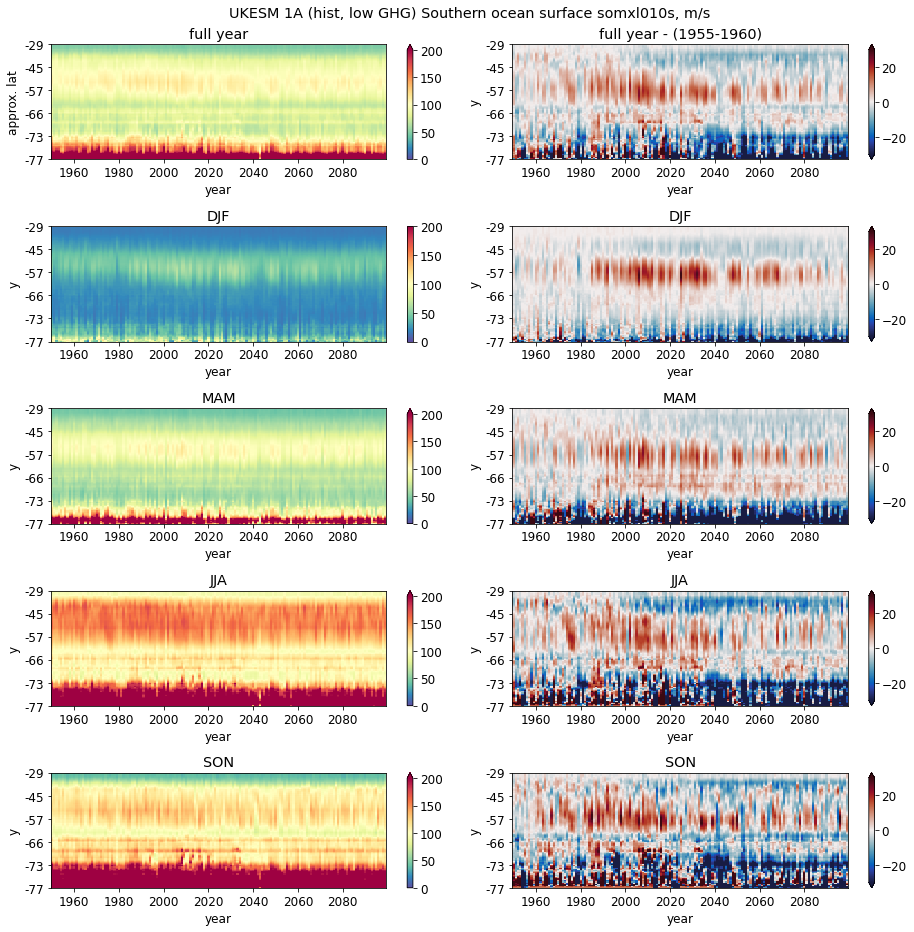

In [8]:
UKESM_1A_somxl010 = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_somxl010_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_somxl010_base_hovmoller.png'
stit = 'UKESM 1A (hist, low GHG) Southern ocean surface somxl010s, m/s'
var = UKESM_1A_somxl010

tvmin = 0
tvmax = 200
tcmap = 'Spectral_r'
tcmap_diff = cm.balance
dmin = -30
dmax = 30

hovmol_ukesm(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_diff, stit, fnam)





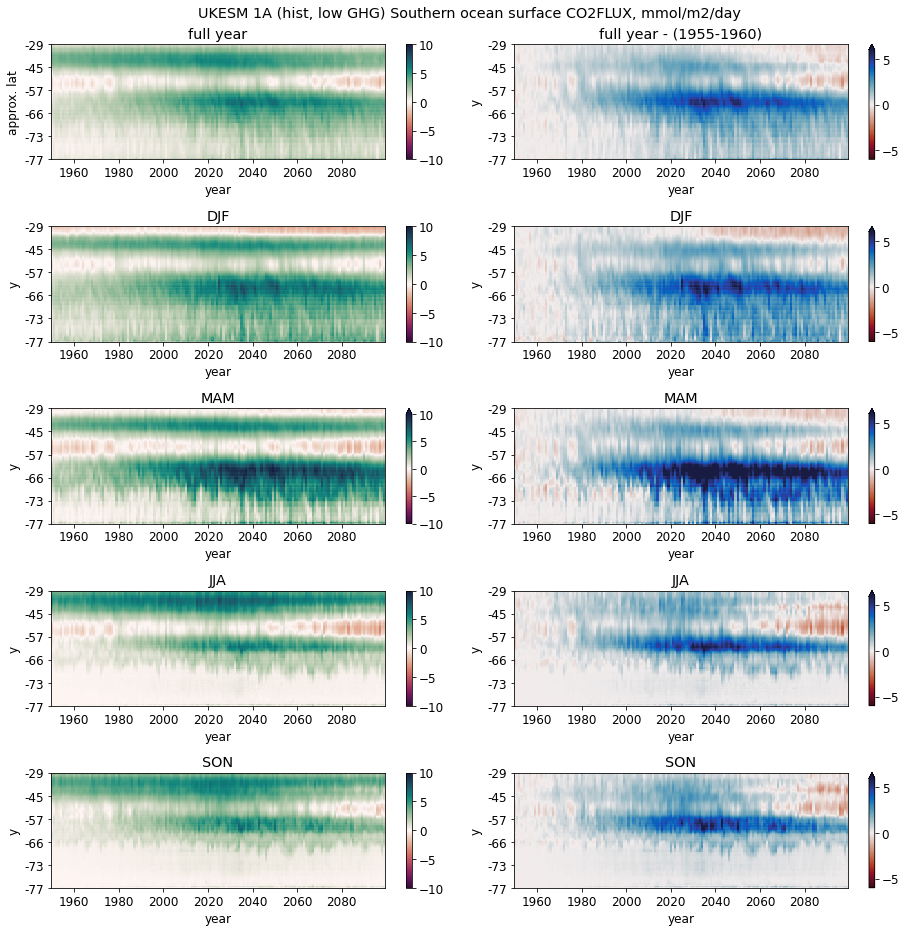

In [9]:
UKESM_1A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_CO2FLUX_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_CO2FLUX_base_hovmoller.png'
stit = 'UKESM 1A (hist, low GHG) Southern ocean surface CO2FLUX, mmol/m2/day'
var = UKESM_1A_CO2FLUX

tvmin = -10
tvmax = 10
tcmap = cm.curl_r
tcmap_diff = cm.balance_r
dmin = -6
dmax = 6

hovmol_ukesm(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_diff, stit, fnam)


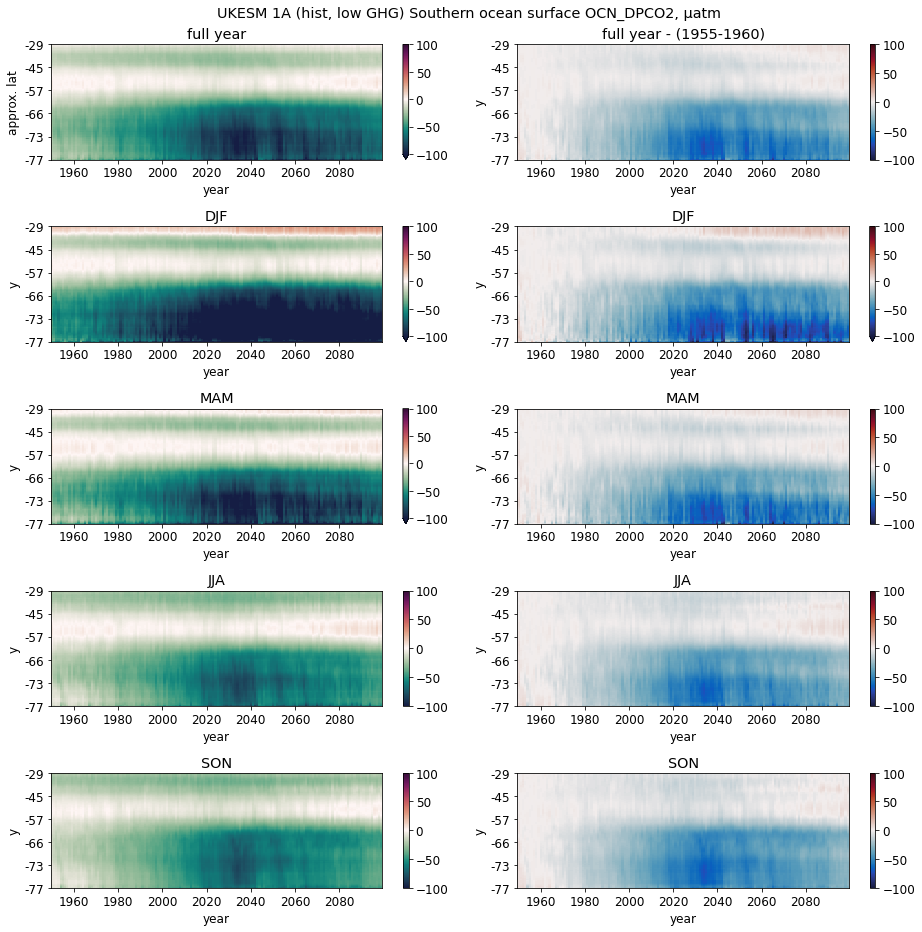

In [10]:
UKESM_1A_OCN_DPCO2 = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_OCN_DPCO2_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_OCN_DPCO2_base_hovmoller.png'
stit = 'UKESM 1A (hist, low GHG) Southern ocean surface OCN_DPCO2, µatm'
var = UKESM_1A_OCN_DPCO2

tvmin = -100
tvmax = 100
tcmap = cm.curl
tcmap_diff = cm.balance
dmin = -100
dmax = 100

hovmol_ukesm(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_diff, stit, fnam)


interlude - make hovmollers out of the tom calculated winds

In [11]:
extract = False
if extract:
    scens = ['1A','1B','2A','2B','3A','3B']

    for scen in scens:
        mon = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc'
        tom_wind = xr.open_dataset(mon)
        wind_hov = tom_wind['mean_wspd'].weighted(tommesh['area']).mean(dim = ['x']).values

        wind_hov_reshaped = np.zeros([161*12,149])
        ind = 0
        for i in range(0,161):
            wind_hov_reshaped[ind:ind+12,:] = wind_hov[i,0:12,:]
            ind = ind+12

        times = pd.date_range(f"1940/01/01",f"2101/01/01",freq='M',closed='left')

        data_vars = {'mean_wspd':(['time_counter','y'], wind_hov_reshaped,
                                 {'units': 'm/s',
                                  'long_name':'windspeed'}),
                    }

        # define coordinates
        coords = {'time_counter': (['time_counter'], times),
            'y': (['y'], np.arange(0,149,1))}

        attrs = {'made in':'SOZONE/MEDUSA/hovmollers.ipynb',
                'desc': 'from MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_wspd.nc, reshape for hovmoller'
                }

        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)
        ds.to_netcdf(f'./BSUB_extractions/EXTRACT/TOM12_TJ_{scen}SA_WIND_lathovmoller_1940_2100.nc')
        print(f'./BSUB_extractions/EXTRACT/TOM12_TJ_{scen}SA_WIND_lathovmoller_1940_2100.nc')

In [12]:
def hovmol_tom(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_dff, stit, fnam, fact2 = 1):

    latmax_tom = 50
    #get what this variable looked like 1955-1959
    var_base = var.sel(time_counter=slice('1955-01', '1959-12')).groupby('time_counter.month').mean()

    fact = 1.1
    fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    tds = var 
    tds_tp = tds.groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T *fact2
    tds_tp.plot(ax = axs[0], vmin = tvmin, vmax = tvmax, cmap = tcmap)  
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_tp.plot(ax = axs[2], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_tp.plot(ax = axs[4], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_tp.plot(ax = axs[6], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T *fact2
    tds_tp.plot(ax = axs[8], vmin = tvmin, vmax = tvmax, cmap = tcmap)

    tds = var.groupby('time_counter.month') - var_base
    tds_tp = tds.groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_tp.plot(ax = axs[1], vmin = dmin, vmax = dmax, cmap = tcmap_diff)  
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_tp.plot(ax = axs[3], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_tp.plot(ax = axs[5], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_tp.plot(ax = axs[7], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    tds_tp = tds.sel(time_counter=(tds['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_tp.plot(ax = axs[9], vmin = dmin, vmax = dmax, cmap = tcmap_diff)


    for i in range(0,10,1):
        axs[i].set_yticks(np.arange(0,150,10))
        axs[i].set_yticklabels(tomlat)
        axs[i].set_ylim([0,latmax_tom])
        axs[0].set_ylabel('approx. lat')

    ttit = ['full year', 'full year - (1955-1960)','DJF', 'DJF', 'MAM', 'MAM', 'JJA', 'JJA', 'SON', 'SON']
    for i in range(0,10):
        axs[i].set_title(ttit[i])

    fig.suptitle(stit)
    fig.savefig(fnam)
    plt.tight_layout()
    
    

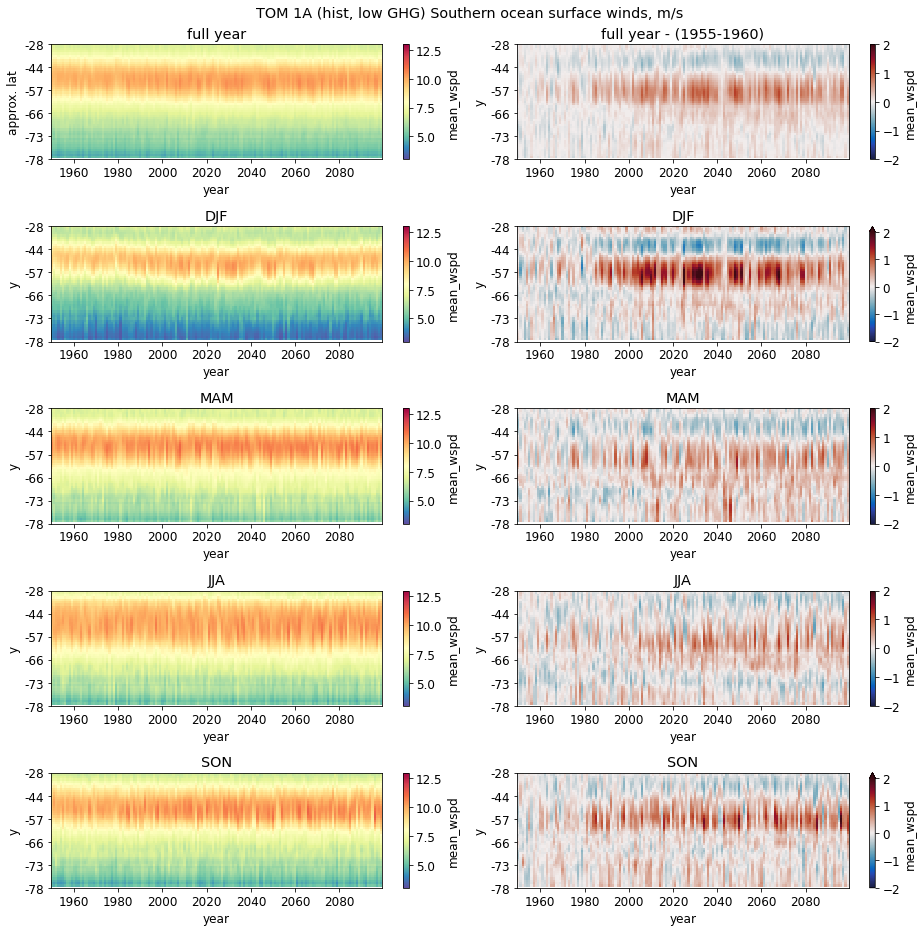

In [13]:
scen = '1A'
w = xr.open_dataset(f'./BSUB_extractions/EXTRACT/TOM12_TJ_{scen}SA_WIND_lathovmoller_1940_2100.nc')
var = w.mean_wspd.sel(time_counter=slice('1950-01', '2099-12'))

fnam = './FIGS/TOM_WIND_base_hovmoller.png'
stit = 'TOM 1A (hist, low GHG) Southern ocean surface winds, m/s'

tvmin = 3
tvmax = 13
tcmap = 'Spectral_r'
tcmap_diff = cm.balance
dmin = -2
dmax = 2

hovmol_tom(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_diff, stit, fnam)




['./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_dpCO2_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_mldkz5_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_Cflx_lathovmoller_1950_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_WIND_lathovmoller_1940_2100.nc', './BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_pCO2_lathovmoller_1950_2100.nc']


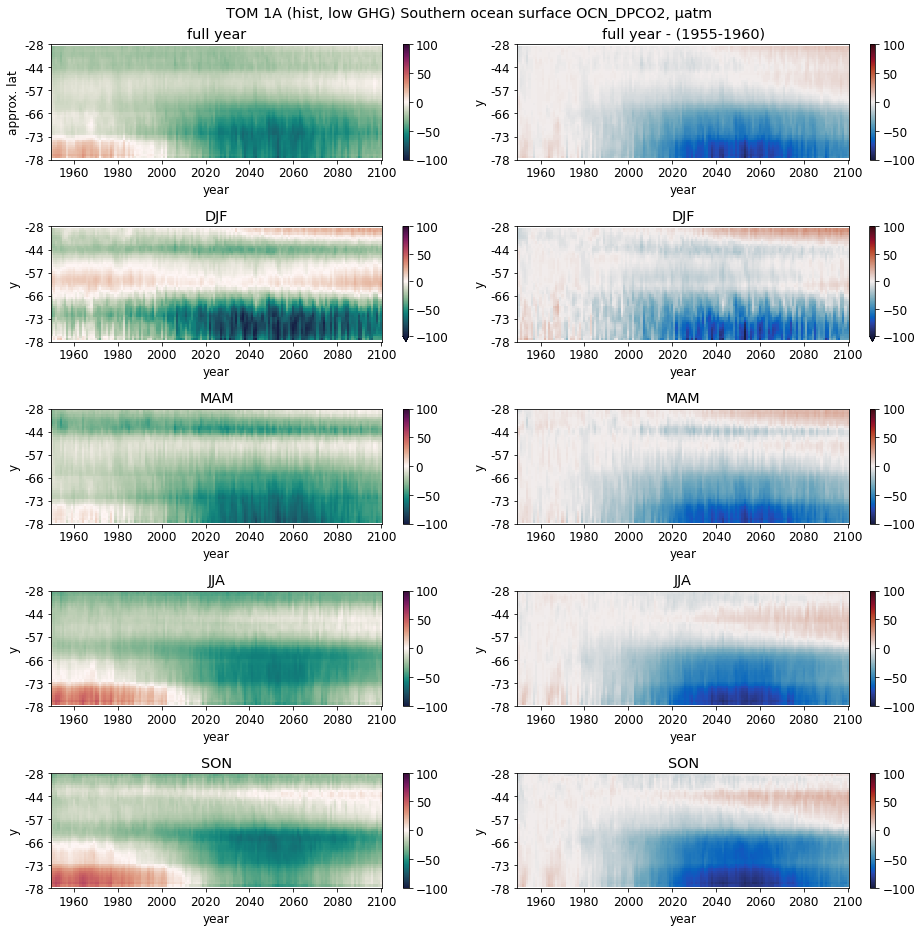

In [14]:
scen = '1A'
w = glob.glob(f'./BSUB_extractions/EXTRACT/TOM12_TJ_{scen}SA_*_lathovmoller_*_2100.nc')
print(w)
w = xr.open_dataset(f'./BSUB_extractions/EXTRACT/TOM12_TJ_{scen}SA_WIND_lathovmoller_1940_2100.nc')


TOM_1A_OCN_DPCO2 = xr.open_dataarray('./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_dpCO2_lathovmoller_1950_2100.nc')

fnam = './FIGS/TOM_OCN_DPCO2_base_hovmoller.png'
stit = 'TOM 1A (hist, low GHG) Southern ocean surface OCN_DPCO2, µatm'
var = TOM_1A_OCN_DPCO2

tvmin = -100
tvmax = 100
tcmap = cm.curl
tcmap_diff = cm.balance
dmin = -100
dmax = 100


hovmol_tom(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_diff, stit, fnam)



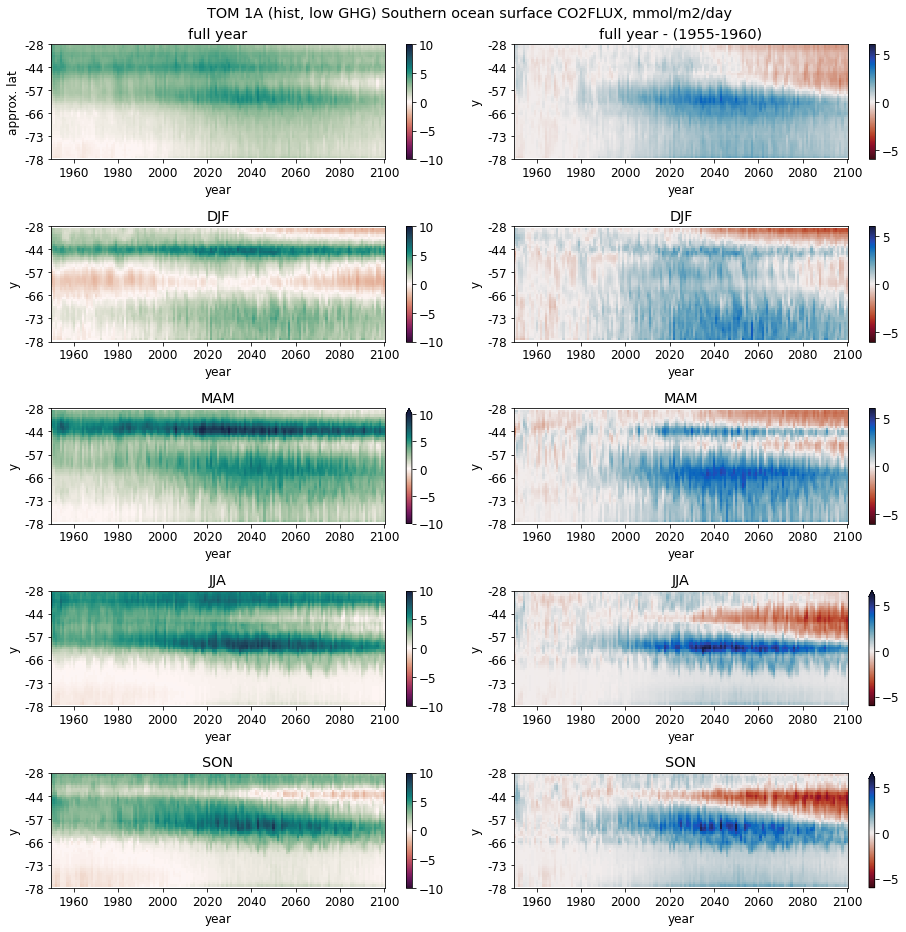

In [15]:
TOM_1A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_Cflx_lathovmoller_1950_2100.nc')

fnam = './FIGS/TOM_CO2FLUX_base_hovmoller.png'
stit = 'TOM 1A (hist, low GHG) Southern ocean surface CO2FLUX, mmol/m2/day'
var = TOM_1A_CO2FLUX

tvmin = -10
tvmax = 10
tcmap = cm.curl_r
tcmap_diff = cm.balance_r
dmin = -6
dmax = 6
fact2 = 1000*60*60*24
hovmol_tom(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_diff, stit, fnam, fact2 = fact2)


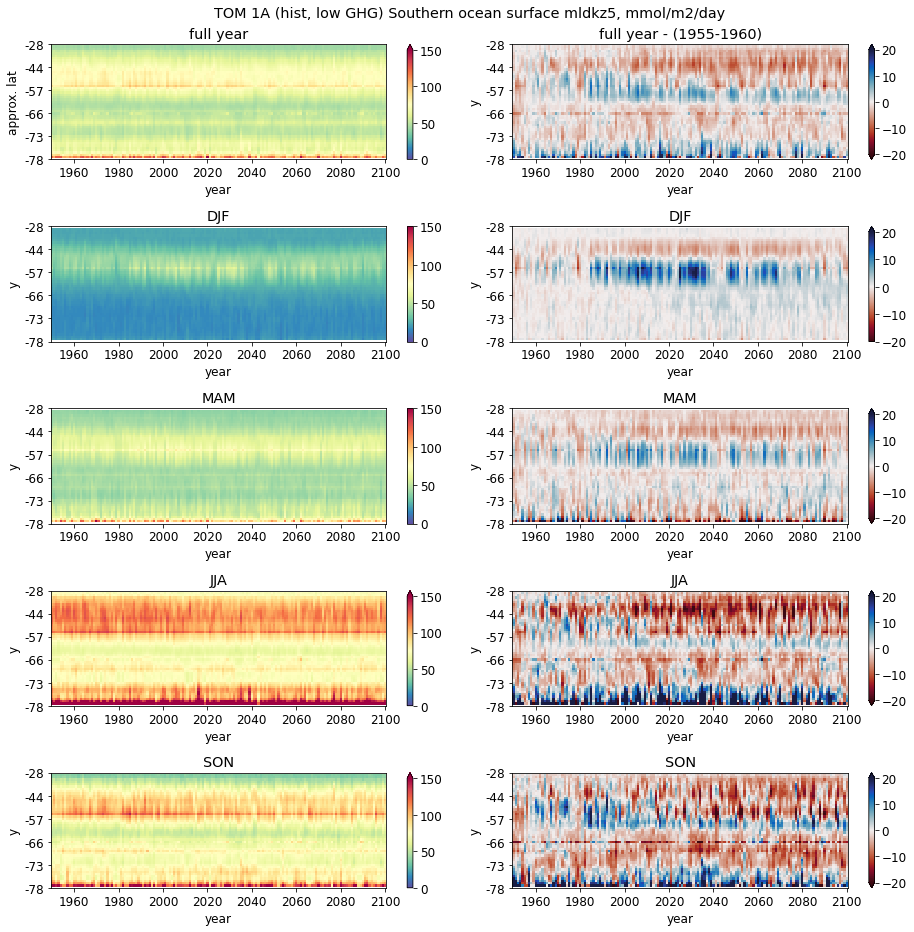

In [16]:
TOM_1A_mldkz5 = xr.open_dataarray('./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_mldkz5_lathovmoller_1950_2100.nc')

fnam = './FIGS/TOM_mldkz5_base_hovmoller.png'
stit = 'TOM 1A (hist, low GHG) Southern ocean surface mldkz5, mmol/m2/day'
var = TOM_1A_mldkz5

tvmin = 0
tvmax = 150
tcmap = 'Spectral_r'
tcmap_diff = cm.balance_r
dmin = -20
dmax = 20
fact2 = 1

hovmol_tom(var, tvmin, tvmax, dmin, dmax, tcmap, tcmap_diff, stit, fnam, fact2 = fact2)


### difference hovmollers

In [17]:
def ukesm_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = 1, fnam = '', stit = ''):

    tds_1A = var_1A 
    tds_1A_yr_tp = tds_1A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T
    tds_1A_DJF_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T *fact2
    tds_1A_MAM_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T *fact2
    tds_1A_JJA_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_1A_SON_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2

    tds_2A = var_2A 
    tds_2A_yr_tp = tds_2A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T 
    tds_2A_DJF_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_2A_MAM_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_2A_JJA_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_2A_SON_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2

    tds_3A = var_3A 
    tds_3A_yr_tp = tds_3A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T 
    tds_3A_DJF_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_3A_MAM_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_3A_JJA_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_3A_SON_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2

    tds_1B = var_1B 
    tds_1B_yr_tp = tds_1B.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T 
    tds_1B_DJF_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_1B_MAM_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_1B_JJA_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
    tds_1B_SON_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2

    fact = 1.1
    fig, axs = plt.subplots(5,4, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    ind = 0
    (tds_1A_yr_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_yr_tp-tds_2A_yr_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_yr_tp-tds_3A_yr_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_yr_tp-tds_1B_yr_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 4
    (tds_1A_DJF_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_DJF_tp-tds_2A_DJF_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_DJF_tp-tds_3A_DJF_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_DJF_tp-tds_1B_DJF_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 8
    (tds_1A_MAM_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_MAM_tp-tds_2A_MAM_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_MAM_tp-tds_3A_MAM_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_MAM_tp-tds_1B_MAM_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 12
    (tds_1A_JJA_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_JJA_tp-tds_2A_JJA_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_JJA_tp-tds_3A_JJA_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_JJA_tp-tds_1B_JJA_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 16
    (tds_1A_SON_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_SON_tp-tds_2A_SON_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_SON_tp-tds_3A_SON_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_SON_tp-tds_1B_SON_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)


    for i in range(0,20,1):
        axs[i].set_yticks(np.arange(0,330,20))
        axs[i].set_yticklabels(ukesmlat)
        axs[i].set_ylim([40,latmax_ukesm])
        axs[i].set_ylabel('approx. lat')

        ttit = ['1A (hist. ozone, low GHG) \n full year', 
                '1A-2A (hist. ozone - (no hole), low GHG) \n full year',
                '1A-3A (hist. ozone - (1990 hole forever), low GHG) \n full year',
                '1A-1B (hist.ozone, low GHG - high GHG), \n full year',
                'DJF', 'DJF', 'DJF', 'DJF', 
                'MAM', 'MAM', 'MAM', 'MAM', 
                'JJA', 'JJA', 'JJA', 'JJA', 
                'SON', 'SON', 'SON', 'SON']
        for i in range(0,20):
            axs[i].set_title(ttit[i])
            
    plt.suptitle(stit)
    plt.tight_layout()
    fig.savefig(fnam)



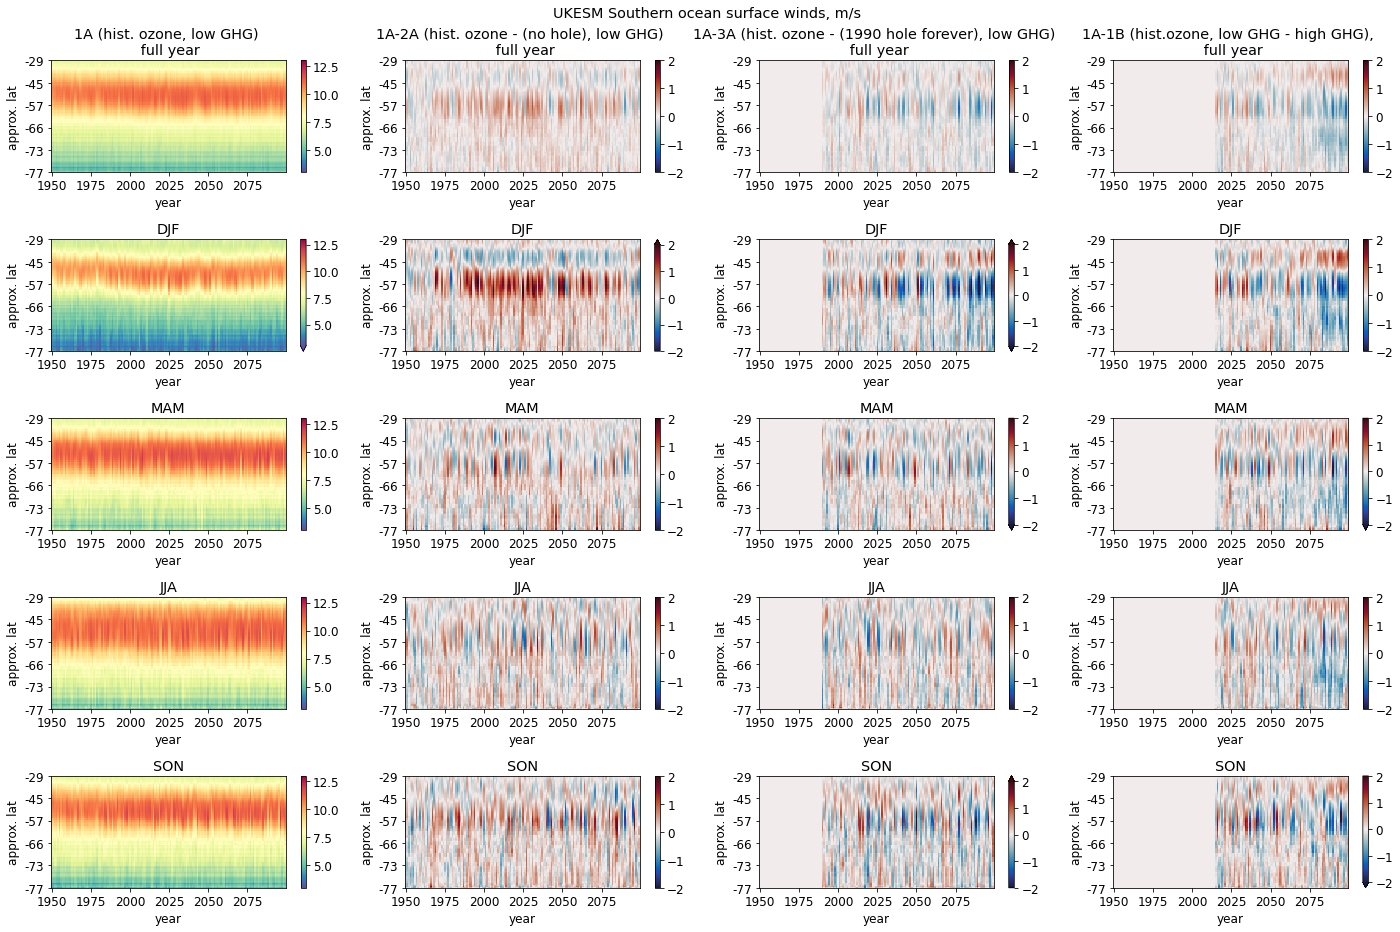

In [18]:
UKESM_1A_WIND = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_WIND_lathovmoller_1950_2100.nc')
UKESM_2A_WIND = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_2A_WIND_lathovmoller_1950_2100.nc')
UKESM_3A_WIND = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_3A_WIND_lathovmoller_1950_2100.nc')
UKESM_1B_WIND = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1B_WIND_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_WIND_diff_hovmoller.png'
stit = 'UKESM Southern ocean surface winds, m/s'
var_1A = UKESM_1A_WIND
var_2A = UKESM_2A_WIND
var_3A = UKESM_3A_WIND
var_1B = UKESM_1B_WIND

tvmin = 3
tvmax = 13
tcmap = 'Spectral_r'
tcmap_diff = cm.balance
dmin = -2
dmax = 2

fact2 = 1

#######
ukesm_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = 1, fnam = fnam, stit = stit)

In [ ]:
def ukesm_diffhovmol2(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = 1, fnam = '', stit = ''):

    tds_1A = var_1A 
    tds_1A_yr_tp = tds_1A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T
    tds_1A_DJF_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T *fact2
#     tds_1A_MAM_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T *fact2
#     tds_1A_JJA_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_1A_SON_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2

    tds_2A = var_2A 
    tds_2A_yr_tp = tds_2A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T 
    tds_2A_DJF_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_2A_MAM_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_2A_JJA_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_2A_SON_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2

    tds_3A = var_3A 
    tds_3A_yr_tp = tds_3A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T 
    tds_3A_DJF_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_3A_MAM_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_3A_JJA_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_3A_SON_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2

    tds_1B = var_1B 
    tds_1B_yr_tp = tds_1B.groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T 
    tds_1B_DJF_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_1B_MAM_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_1B_JJA_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2
#     tds_1B_SON_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T*fact2

    fact = 1.1
    fig, axs = plt.subplots(5,4, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

#     ind = 0
#     (tds_1A_yr_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
#     (tds_1A_yr_tp-tds_2A_yr_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
#     (tds_1A_yr_tp-tds_3A_yr_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
#     (tds_1A_yr_tp-tds_1B_yr_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 4
    (tds_1A_DJF_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_DJF_tp-tds_2A_DJF_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_DJF_tp-tds_3A_DJF_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_DJF_tp-tds_1B_DJF_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 8
    (tds_1A_MAM_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_MAM_tp-tds_2A_MAM_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_MAM_tp-tds_3A_MAM_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_MAM_tp-tds_1B_MAM_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 12
    (tds_1A_JJA_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_JJA_tp-tds_2A_JJA_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_JJA_tp-tds_3A_JJA_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_JJA_tp-tds_1B_JJA_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 16
    (tds_1A_SON_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_SON_tp-tds_2A_SON_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_SON_tp-tds_3A_SON_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_SON_tp-tds_1B_SON_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)


    for i in range(0,20,1):
        axs[i].set_yticks(np.arange(0,330,20))
        axs[i].set_yticklabels(ukesmlat)
        axs[i].set_ylim([40,latmax_ukesm])
        axs[i].set_ylabel('approx. lat')

        ttit = ['1A (hist. ozone, low GHG) \n full year', 
                '1A-2A (hist. ozone - (no hole), low GHG) \n full year',
                '1A-3A (hist. ozone - (1990 hole forever), low GHG) \n full year',
                '1A-1B (hist.ozone, low GHG - high GHG), \n full year',
                'DJF', 'DJF', 'DJF', 'DJF', 
                'MAM', 'MAM', 'MAM', 'MAM', 
                'JJA', 'JJA', 'JJA', 'JJA', 
                'SON', 'SON', 'SON', 'SON']
        for i in range(0,20):
            axs[i].set_title(ttit[i])
            
    plt.suptitle(stit)
    plt.tight_layout()
    fig.savefig(fnam)



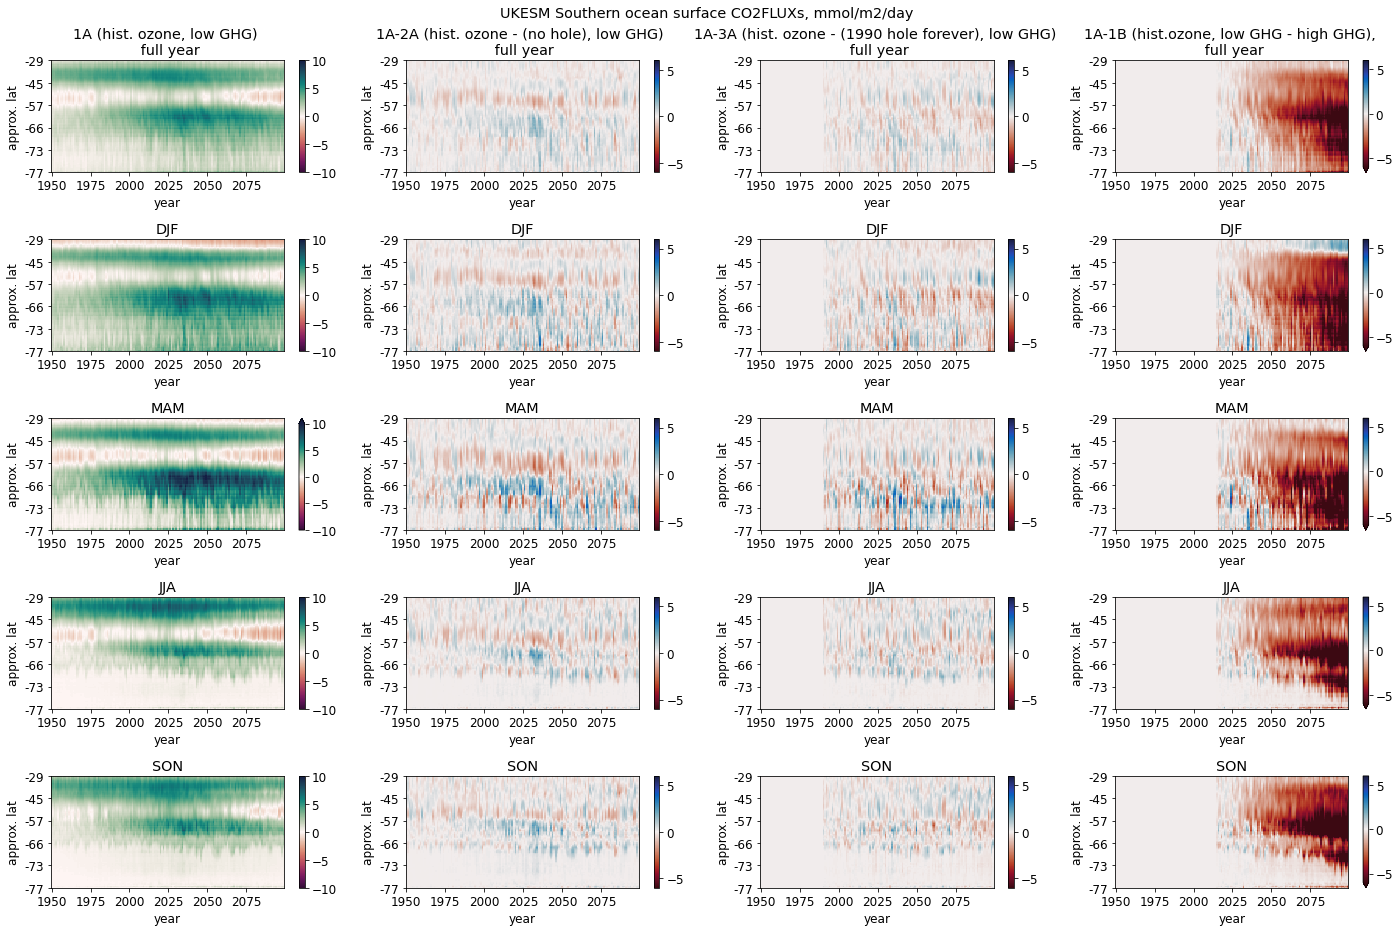

In [19]:
UKESM_1A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_2A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_2A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_3A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_3A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_1B_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1B_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_2B_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_2B_CO2FLUX_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_CO2FLUX_diff_hovmoller.png'
stit = 'UKESM Southern ocean surface CO2FLUXs, mmol/m2/day'
var_1A = UKESM_1A_CO2FLUX
var_2A = UKESM_2A_CO2FLUX
var_3A = UKESM_3A_CO2FLUX
var_1B = UKESM_1B_CO2FLUX

tvmin = -10
tvmax = 10
tcmap = cm.curl_r
tcmap_diff = cm.balance_r
dmin = -6
dmax = 6
fact2 = 1

#######
ukesm_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2, fnam = fnam, stit = stit)

<xarray.DataArray (y: 140, year: 150)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.97332492, -1.08501019, -0.75496701, ..., -2.09267503,
        -2.03808863, -1.64212015],
       [-1.22837476, -1.35874807, -1.01419728, ..., -2.30232503,
        -2.22835012, -1.82963693],
       [-1.4781845 , -1.62966984, -1.31804791, ..., -2.49834379,
        -2.39842396, -2.00764683]])
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
Dimensions without coordinates: y


Text(0.5, 0.98, 'CO$_2$ flux response, UKESM')

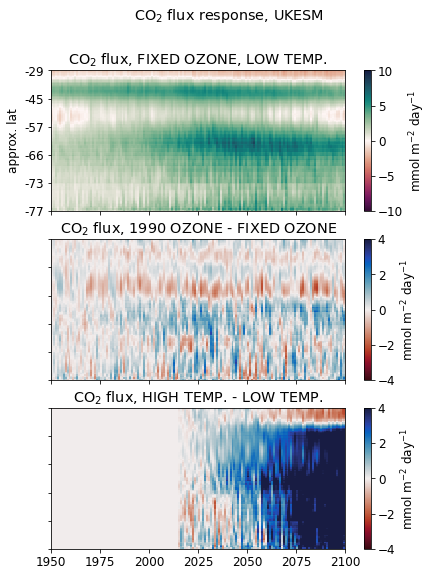

In [66]:
UKESM_1A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_2A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_2A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_3A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_3A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_1B_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1B_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_2B_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_2B_CO2FLUX_lathovmoller_1950_2100.nc')

fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(6*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


tvmin = -10
tvmax = 10
tcmap = cm.curl_r
tcmap_diff = cm.balance_r
dmin = -4
dmax = 4
fact2 = 1

tds_2A_yr_tp = UKESM_2A_CO2FLUX.sel(time_counter=(UKESM_2A_CO2FLUX['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T
print(tds_2A_yr_tp)
tds_2B_yr_tp = UKESM_2B_CO2FLUX.sel(time_counter=(UKESM_2A_CO2FLUX['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T 
tds_3A_yr_tp = UKESM_3A_CO2FLUX.sel(time_counter=(UKESM_2A_CO2FLUX['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_ukesm)).T
#tds_2A_yr_tp.plot(ax = axs[0], vmin = tvmin, vmax = tvmax, cmap = tcmap_diff)
w = axs[0].pcolormesh(tds_2A_yr_tp, vmin = tvmin, vmax = tvmax, cmap = tcmap)
plt.colorbar(w, ax = axs[0], label = 'mmol m$^{-2}$ day$^{-1}$')
w2= axs[1].pcolormesh(tds_3A_yr_tp-tds_2A_yr_tp, vmin = dmin, vmax = dmax, cmap = tcmap_diff)
plt.colorbar(w2, ax = axs[1], label = 'mmol m$^{-2}$ day$^{-1}$ ')
w3 = axs[2].pcolormesh(tds_2B_yr_tp-tds_2A_yr_tp, vmin = dmin, vmax = dmax, cmap = tcmap_diff)
plt.colorbar(w3, ax = axs[2], label = 'mmol m$^{-2}$ day$^{-1}$ ')

for i in range(0,3,1):
    axs[i].set_yticks(np.arange(0,330,20))
    
    axs[i].set_yticklabels('')
    axs[0].set_yticklabels(ukesmlat)
    axs[i].set_xticks(np.arange(0,175,25))
    axs[i].set_xticklabels('')
    axs[2].set_xticklabels(np.arange(1950,2125,25))
    axs[i].set_ylim([40,latmax_ukesm])
    axs[0].set_ylabel('approx. lat')
    
axs[0].set_title('CO$_2$ flux, FIXED OZONE, LOW TEMP.')
axs[1].set_title('CO$_2$ flux, 1990 OZONE - FIXED OZONE')
axs[2].set_title('CO$_2$ flux, HIGH TEMP. - LOW TEMP.')
plt.suptitle('CO$_2$ flux response, UKESM')

<xarray.DataArray (y: 50, year: 151)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-2.47222314e-09,  3.14765138e-09,  6.70940802e-09, ...,
         1.95759344e-08,  1.28160301e-08,  2.19883352e-08],
       [-1.10939395e-09, -1.30325887e-09,  1.33976052e-09, ...,
         1.96460033e-08,  1.30097429e-08,  2.10456252e-08],
       ...,
       [ 2.56192593e-08,  1.71460016e-08,  2.44556285e-08, ...,
        -1.34534507e-08, -1.01080380e-08, -1.47470367e-08],
       [ 2.40958883e-08,  1.63300104e-08,  2.46527302e-08, ...,
        -1.97276806e-08, -1.62857741e-08, -2.21013446e-08],
       [ 2.38399972e-08,  1.68160325e-08,  2.52115318e-08, ...,
        -2.13470289e-08, -1.74717944e-08, -2.32748828e-08]])
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: y


Text(0.5, 0.98, 'CO$_2$ flux response, TOM12')

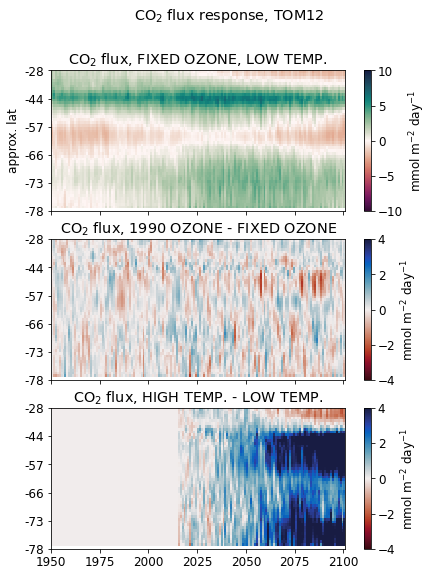

In [67]:
TOM12_TJ_1A_Cflx = xr.open_dataarray('./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_Cflx_lathovmoller_1950_2100.nc')
TOM12_TJ_2A_Cflx = xr.open_dataarray('./BSUB_extractions/EXTRACT/TOM12_TJ_2ASA_Cflx_lathovmoller_1950_2100.nc')
TOM12_TJ_3A_Cflx = xr.open_dataarray('./BSUB_extractions/EXTRACT/TOM12_TJ_3ASA_Cflx_lathovmoller_1950_2100.nc')
TOM12_TJ_1B_Cflx = xr.open_dataarray('./BSUB_extractions/EXTRACT/TOM12_TJ_1BSA_Cflx_lathovmoller_1950_2100.nc')
TOM12_TJ_2B_Cflx = xr.open_dataarray('./BSUB_extractions/EXTRACT/TOM12_TJ_2BSA_Cflx_lathovmoller_1950_2100.nc')

fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(6*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


tvmin = -10
tvmax = 10
tcmap = cm.curl_r
tcmap_diff = cm.balance_r
dmin = -4
dmax = 4
fact2 = 1000*60*60*24

tds_2A_yr_tp = TOM12_TJ_2A_Cflx.sel(time_counter=(TOM12_TJ_2A_Cflx['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,50)).T
print(tds_2A_yr_tp)
tds_2B_yr_tp = TOM12_TJ_2B_Cflx.sel(time_counter=(TOM12_TJ_2A_Cflx['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,50)).T 
tds_3A_yr_tp = TOM12_TJ_3A_Cflx.sel(time_counter=(TOM12_TJ_2A_Cflx['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,50)).T
#tds_2A_yr_tp.plot(ax = axs[0], vmin = tvmin, vmax = tvmax, cmap = tcmap_diff)
w = axs[0].pcolormesh(tds_2A_yr_tp*fact2, vmin = tvmin, vmax = tvmax, cmap = tcmap)
plt.colorbar(w, ax = axs[0], label = 'mmol m$^{-2}$ day$^{-1}$')
w2= axs[1].pcolormesh((tds_3A_yr_tp-tds_2A_yr_tp)*fact2, vmin = dmin, vmax = dmax, cmap = tcmap_diff)
plt.colorbar(w2, ax = axs[1], label = 'mmol m$^{-2}$ day$^{-1}$ ')
w3 = axs[2].pcolormesh((tds_2B_yr_tp-tds_2A_yr_tp)*fact2, vmin = dmin, vmax = dmax, cmap = tcmap_diff)
plt.colorbar(w3, ax = axs[2], label = 'mmol m$^{-2}$ day$^{-1}$ ')

for i in range(0,3,1):
    axs[i].set_yticks(np.arange(0,330,20))
    
    axs[i].set_yticklabels('')
#     axs[0].set_yticklabels(TOM12_TJlat)
    axs[i].set_xticks(np.arange(0,175,25))
    axs[i].set_xticklabels('')
    axs[2].set_xticklabels(np.arange(1950,2125,25))
    axs[i].set_ylim([0,50])
    axs[i].set_yticks(np.arange(0,150,10))
    axs[i].set_yticklabels(tomlat)
    axs[i].set_ylim([0,latmax_tom])
    axs[0].set_ylabel('approx. lat')
axs[0].set_title('CO$_2$ flux, FIXED OZONE, LOW TEMP.')
axs[1].set_title('CO$_2$ flux, 1990 OZONE - FIXED OZONE')
axs[2].set_title('CO$_2$ flux, HIGH TEMP. - LOW TEMP.')
plt.suptitle('CO$_2$ flux response, TOM12')

In [ ]:
UKESM_1A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_2A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_2A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_3A_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_3A_CO2FLUX_lathovmoller_1950_2100.nc')
UKESM_1B_CO2FLUX = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1B_CO2FLUX_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_CO2FLUX_diff_hovmoller.png'
stit = 'UKESM Southern ocean surface CO2FLUXs, mmol/m2/day'
var_1A = UKESM_1A_CO2FLUX
var_2A = UKESM_2A_CO2FLUX
var_3A = UKESM_3A_CO2FLUX
var_1B = UKESM_1B_CO2FLUX

tvmin = -10
tvmax = 10
tcmap = cm.curl_r
tcmap_diff = cm.balance_r
dmin = -6
dmax = 6
fact2 = 1

#######
ukesm_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2, fnam = fnam, stit = stit)

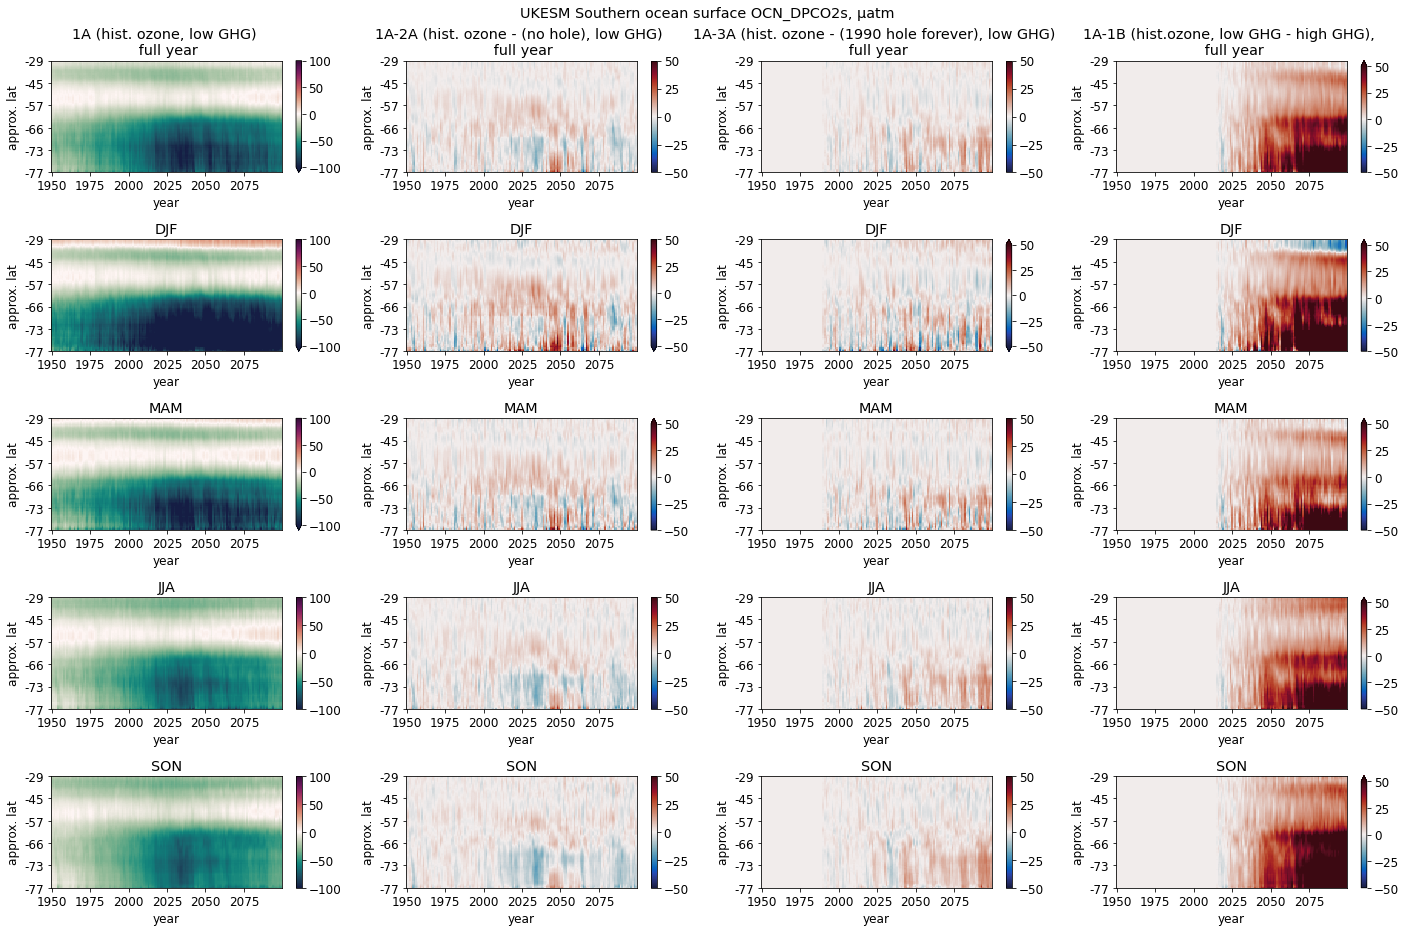

In [20]:
UKESM_1A_OCN_DPCO2 = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1A_OCN_DPCO2_lathovmoller_1950_2100.nc')
UKESM_2A_OCN_DPCO2 = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_2A_OCN_DPCO2_lathovmoller_1950_2100.nc')
UKESM_3A_OCN_DPCO2 = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_3A_OCN_DPCO2_lathovmoller_1950_2100.nc')
UKESM_1B_OCN_DPCO2 = xr.open_dataarray('./BSUB_extractions/EXTRACT/UKESM_1B_OCN_DPCO2_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_OCN_DPCO2_diff_hovmoller.png'
stit = 'UKESM Southern ocean surface OCN_DPCO2s, µatm'
var_1A = UKESM_1A_OCN_DPCO2
var_2A = UKESM_2A_OCN_DPCO2
var_3A = UKESM_3A_OCN_DPCO2
var_1B = UKESM_1B_OCN_DPCO2

tvmin = -100
tvmax = 100
tcmap = cm.curl
tcmap_diff = cm.balance
dmin = -50
dmax = 50

#######
ukesm_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2, fnam = fnam, stit = stit)

# difference hovmollers, tom

In [21]:
def tom_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = 1, fnam = '', stit = ''):

    tds_1A = var_1A 
    tds_1A_yr_tp = tds_1A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_1A_DJF_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T *fact2
    tds_1A_MAM_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T *fact2
    tds_1A_JJA_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_1A_SON_tp = tds_1A.sel(time_counter=(tds_1A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2

    tds_2A = var_2A 
    tds_2A_yr_tp = tds_2A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T *fact2
    tds_2A_DJF_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_2A_MAM_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_2A_JJA_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_2A_SON_tp = tds_2A.sel(time_counter=(tds_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2

    tds_3A = var_3A 
    tds_3A_yr_tp = tds_3A.groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T *fact2
    tds_3A_DJF_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_3A_MAM_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_3A_JJA_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_3A_SON_tp = tds_3A.sel(time_counter=(tds_3A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2

    tds_1B = var_1B 
    tds_1B_yr_tp = tds_1B.groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T *fact2
    tds_1B_DJF_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_1B_MAM_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_1B_JJA_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2
    tds_1B_SON_tp = tds_1B.sel(time_counter=(tds_1B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().sel(y=slice(0,latmax_tom)).T*fact2

    fact = 1.1
    fig, axs = plt.subplots(5,4, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    ind = 0
    (tds_1A_yr_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_yr_tp-tds_2A_yr_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_yr_tp-tds_3A_yr_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_yr_tp-tds_1B_yr_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 4
    (tds_1A_DJF_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_DJF_tp-tds_2A_DJF_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_DJF_tp-tds_3A_DJF_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_DJF_tp-tds_1B_DJF_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 8
    (tds_1A_MAM_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_MAM_tp-tds_2A_MAM_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_MAM_tp-tds_3A_MAM_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_MAM_tp-tds_1B_MAM_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 12
    (tds_1A_JJA_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_JJA_tp-tds_2A_JJA_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_JJA_tp-tds_3A_JJA_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_JJA_tp-tds_1B_JJA_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)

    ind = 16
    (tds_1A_SON_tp).plot(ax = axs[0+ind], vmin = tvmin, vmax = tvmax, cmap = tcmap)
    (tds_1A_SON_tp-tds_2A_SON_tp).plot(ax = axs[1+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_SON_tp-tds_3A_SON_tp).plot(ax = axs[2+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)
    (tds_1A_SON_tp-tds_1B_SON_tp).plot(ax = axs[3+ind], vmin = dmin, vmax = dmax, cmap = tcmap_diff)


    for i in range(0,20,1):
        axs[i].set_yticks(np.arange(0,150,10))
        axs[i].set_yticklabels(tomlat)
        axs[i].set_ylim([0,latmax_tom])
        axs[0].set_ylabel('approx. lat')

        ttit = ['1A (hist. ozone, low GHG) \n full year', 
                '1A-2A (hist. ozone - (no hole), low GHG) \n full year',
                '1A-3A (hist. ozone - (1990 hole forever), low GHG) \n full year',
                '1A-1B (hist.ozone, low GHG - high GHG), \n full year',
                'DJF', 'DJF', 'DJF', 'DJF', 
                'MAM', 'MAM', 'MAM', 'MAM', 
                'JJA', 'JJA', 'JJA', 'JJA', 
                'SON', 'SON', 'SON', 'SON']
        for i in range(0,20):
            axs[i].set_title(ttit[i])
            
    plt.suptitle(stit)
    plt.tight_layout()
    fig.savefig(fnam)



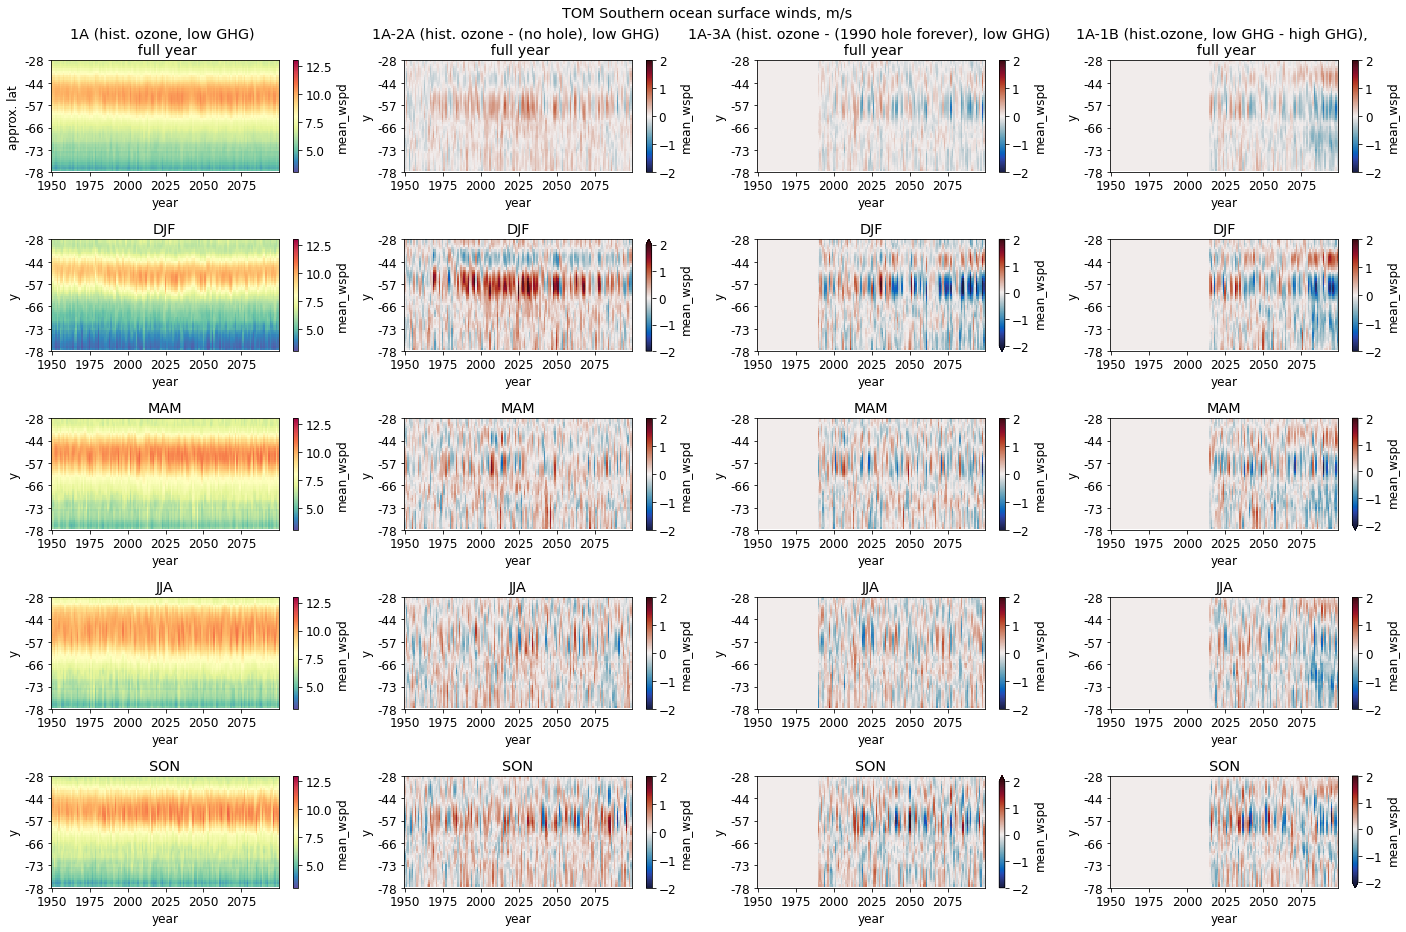

In [22]:

TOM_1A_WIND = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_WIND_lathovmoller_1940_2100.nc')
TOM_2A_WIND = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_2ASA_WIND_lathovmoller_1940_2100.nc')
TOM_3A_WIND = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_3ASA_WIND_lathovmoller_1940_2100.nc')
TOM_1B_WIND = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_1BSA_WIND_lathovmoller_1940_2100.nc')

fnam = './FIGS/TOM_WIND_diff_hovmoller.png'
stit = 'TOM Southern ocean surface winds, m/s'
var_1A = TOM_1A_WIND.sel(time_counter=slice('1950-01', '2099-12'))
var_2A = TOM_2A_WIND.sel(time_counter=slice('1950-01', '2099-12'))
var_3A = TOM_3A_WIND.sel(time_counter=slice('1950-01', '2099-12'))
var_1B = TOM_1B_WIND.sel(time_counter=slice('1950-01', '2099-12'))


tvmin = 3
tvmax = 13
tcmap = 'Spectral_r'
tcmap_diff = cm.balance
dmin = -2
dmax = 2

fact2 = 1

#######
tom_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = 1, fnam = fnam, stit = stit)

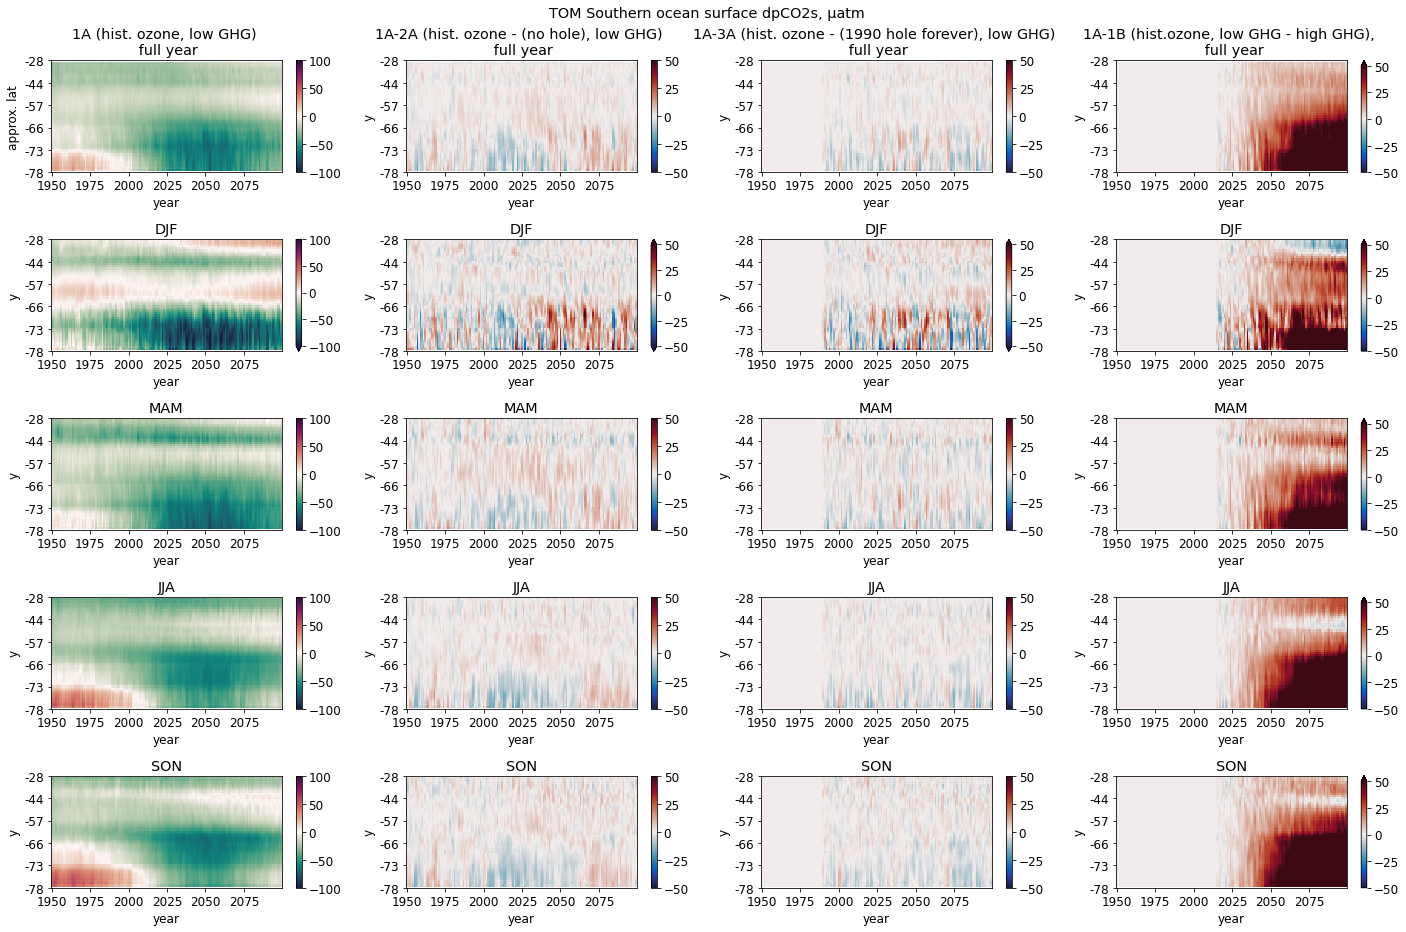

In [23]:

TOM_1A_dpCO2 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_dpCO2_lathovmoller_1950_2100.nc')
TOM_2A_dpCO2 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_2ASA_dpCO2_lathovmoller_1950_2100.nc')
TOM_3A_dpCO2 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_3ASA_dpCO2_lathovmoller_1950_2100.nc')
TOM_1B_dpCO2 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_1BSA_dpCO2_lathovmoller_1950_2100.nc')

fnam = './FIGS/TOM_dpCO2_diff_hovmoller.png'
stit = 'TOM Southern ocean surface dpCO2s, µatm'
var_1A = TOM_1A_dpCO2.sel(time_counter=slice('1950-01', '2099-12'))
var_2A = TOM_2A_dpCO2.sel(time_counter=slice('1950-01', '2099-12'))
var_3A = TOM_3A_dpCO2.sel(time_counter=slice('1950-01', '2099-12'))
var_1B = TOM_1B_dpCO2.sel(time_counter=slice('1950-01', '2099-12'))


tvmin = -100
tvmax = 100
tcmap = cm.curl
tcmap_diff = cm.balance
dmin = -50
dmax = 50

fact2 = 1

#######
tom_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = 1, fnam = fnam, stit = stit)

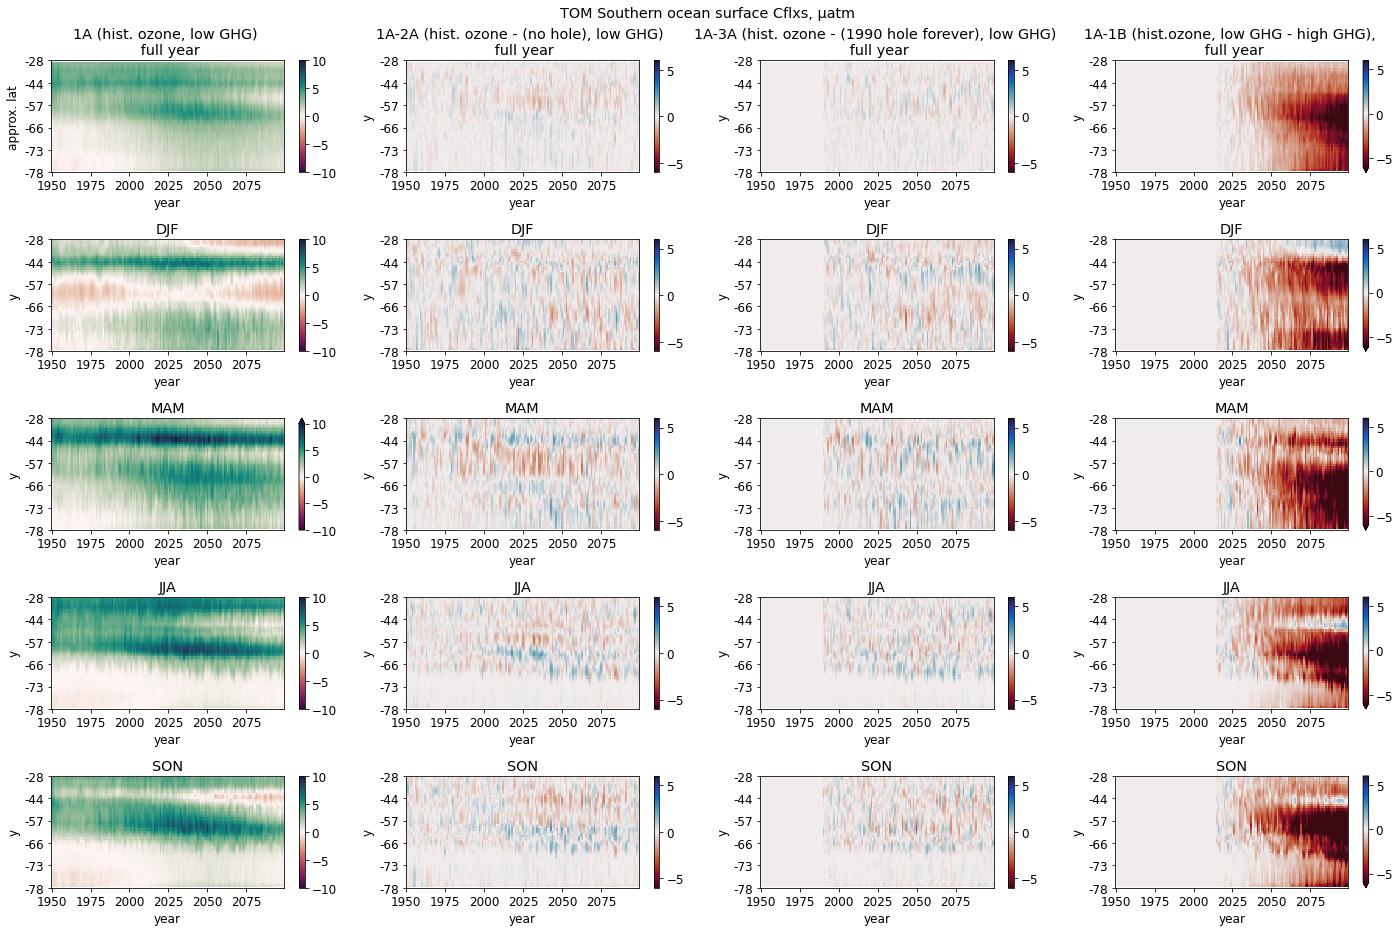

In [24]:

TOM_1A_Cflx = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_Cflx_lathovmoller_1950_2100.nc')
TOM_2A_Cflx = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_2ASA_Cflx_lathovmoller_1950_2100.nc')
TOM_3A_Cflx = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_3ASA_Cflx_lathovmoller_1950_2100.nc')
TOM_1B_Cflx = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_1BSA_Cflx_lathovmoller_1950_2100.nc')

fnam = './FIGS/TOM_Cflx_diff_hovmoller.png'
stit = 'TOM Southern ocean surface Cflxs, µatm'
var_1A = TOM_1A_Cflx.sel(time_counter=slice('1950-01', '2099-12'))
var_2A = TOM_2A_Cflx.sel(time_counter=slice('1950-01', '2099-12'))
var_3A = TOM_3A_Cflx.sel(time_counter=slice('1950-01', '2099-12'))
var_1B = TOM_1B_Cflx.sel(time_counter=slice('1950-01', '2099-12'))


tvmin = -10
tvmax = 10
tcmap = cm.curl_r
tcmap_diff = cm.balance_r
dmin = -6
dmax = 6
fact2 = 60*60*24*1000

#######
tom_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = fact2, fnam = fnam, stit = stit)

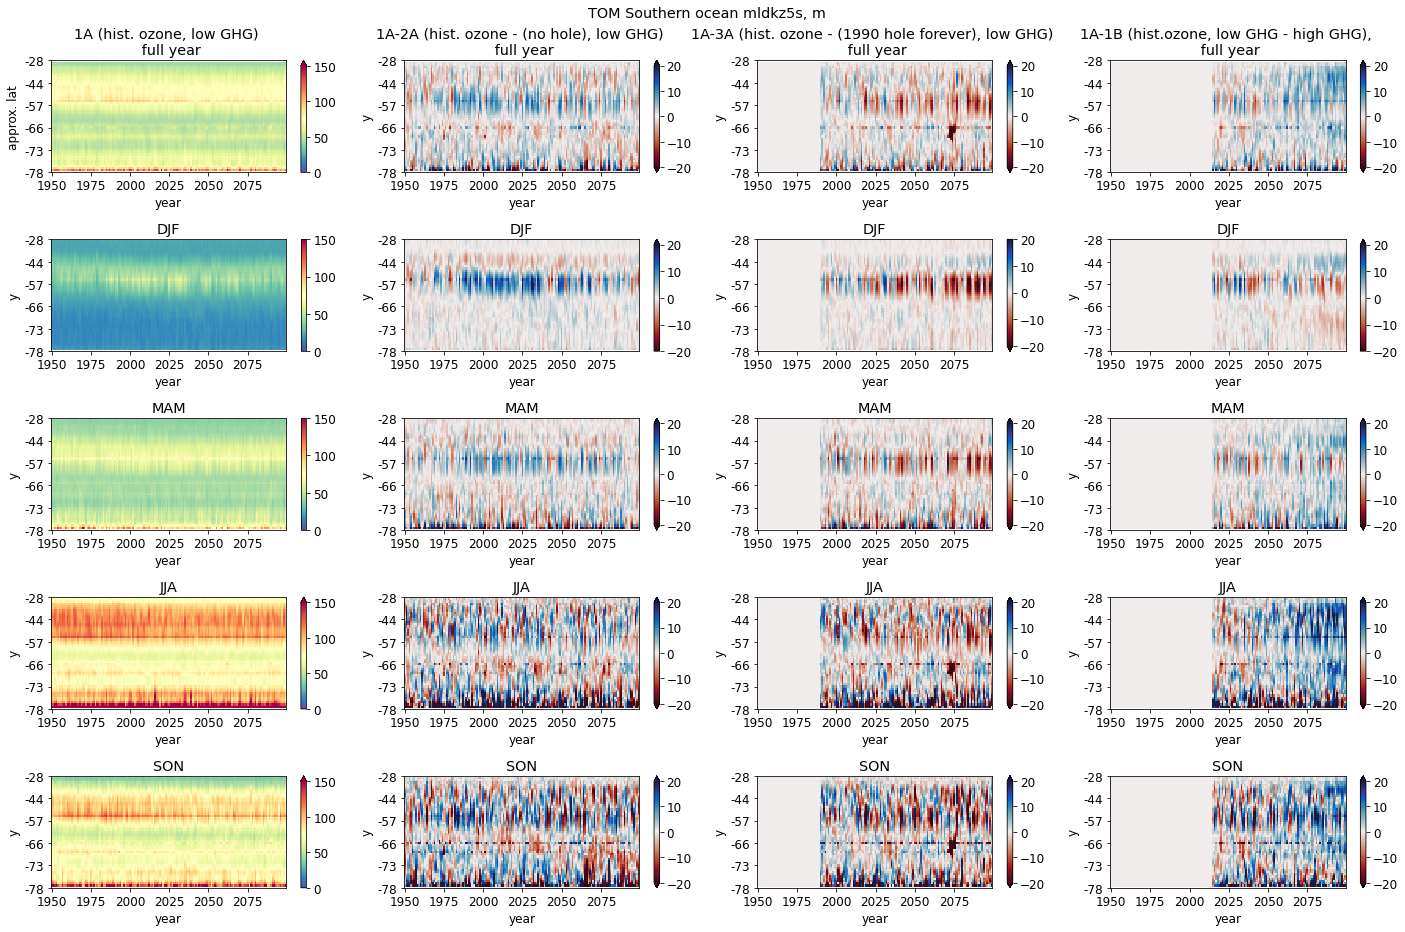

In [25]:

TOM_1A_mldkz5 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_1ASA_mldkz5_lathovmoller_1950_2100.nc')
TOM_2A_mldkz5 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_2ASA_mldkz5_lathovmoller_1950_2100.nc')
TOM_3A_mldkz5 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_3ASA_mldkz5_lathovmoller_1950_2100.nc')
TOM_1B_mldkz5 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/TOM12_TJ_1BSA_mldkz5_lathovmoller_1950_2100.nc')

fnam = './FIGS/TOM_mldkz5_diff_hovmoller.png'
stit = 'TOM Southern ocean mldkz5s, m'
var_1A = TOM_1A_mldkz5.sel(time_counter=slice('1950-01', '2099-12'))
var_2A = TOM_2A_mldkz5.sel(time_counter=slice('1950-01', '2099-12'))
var_3A = TOM_3A_mldkz5.sel(time_counter=slice('1950-01', '2099-12'))
var_1B = TOM_1B_mldkz5.sel(time_counter=slice('1950-01', '2099-12'))


tvmin = 0
tvmax = 150
tcmap = 'Spectral_r'
tcmap_diff = cm.balance_r
dmin = -20
dmax = 20
fact2 = 1

#######
tom_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = fact2, fnam = fnam, stit = stit)

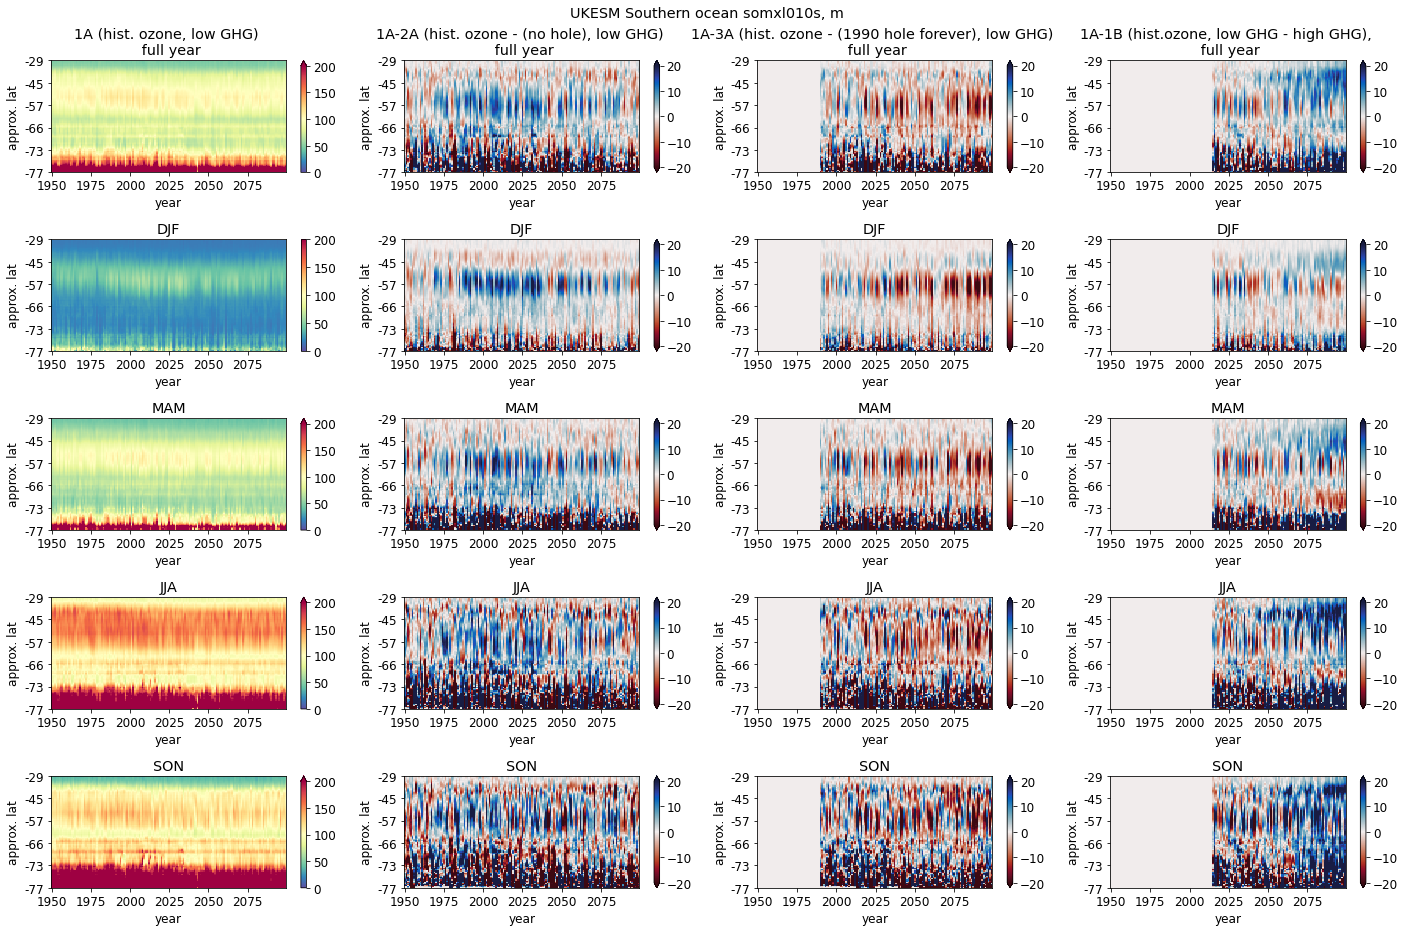

In [26]:

UKESM_1A_somxl010 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/UKESM_1A_somxl010_lathovmoller_1950_2100.nc')
UKESM_2A_somxl010 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/UKESM_2A_somxl010_lathovmoller_1950_2100.nc')
UKESM_3A_somxl010 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/UKESM_3A_somxl010_lathovmoller_1950_2100.nc')
UKESM_1B_somxl010 = xr.open_dataarray(f'./BSUB_extractions/EXTRACT/UKESM_1B_somxl010_lathovmoller_1950_2100.nc')

fnam = './FIGS/UKESM_somxl010_diff_hovmoller.png'
stit = 'UKESM Southern ocean somxl010s, m'
var_1A = UKESM_1A_somxl010.sel(time_counter=slice('1950-01', '2099-12'))
var_2A = UKESM_2A_somxl010.sel(time_counter=slice('1950-01', '2099-12'))
var_3A = UKESM_3A_somxl010.sel(time_counter=slice('1950-01', '2099-12'))
var_1B = UKESM_1B_somxl010.sel(time_counter=slice('1950-01', '2099-12'))


tvmin = 0
tvmax = 200
tcmap = 'Spectral_r'
tcmap_diff = cm.balance_r
dmin = -20
dmax = 20
fact2 = 1

#######
ukesm_diffhovmol(var_1A, var_2A, var_3A, var_1B, tvmin, tvmax, tcmap, tcmap_diff,\
                     dmin, dmax, fact2 = fact2, fnam = fnam, stit = stit)